
# **M5 competition: Predict Future sales **
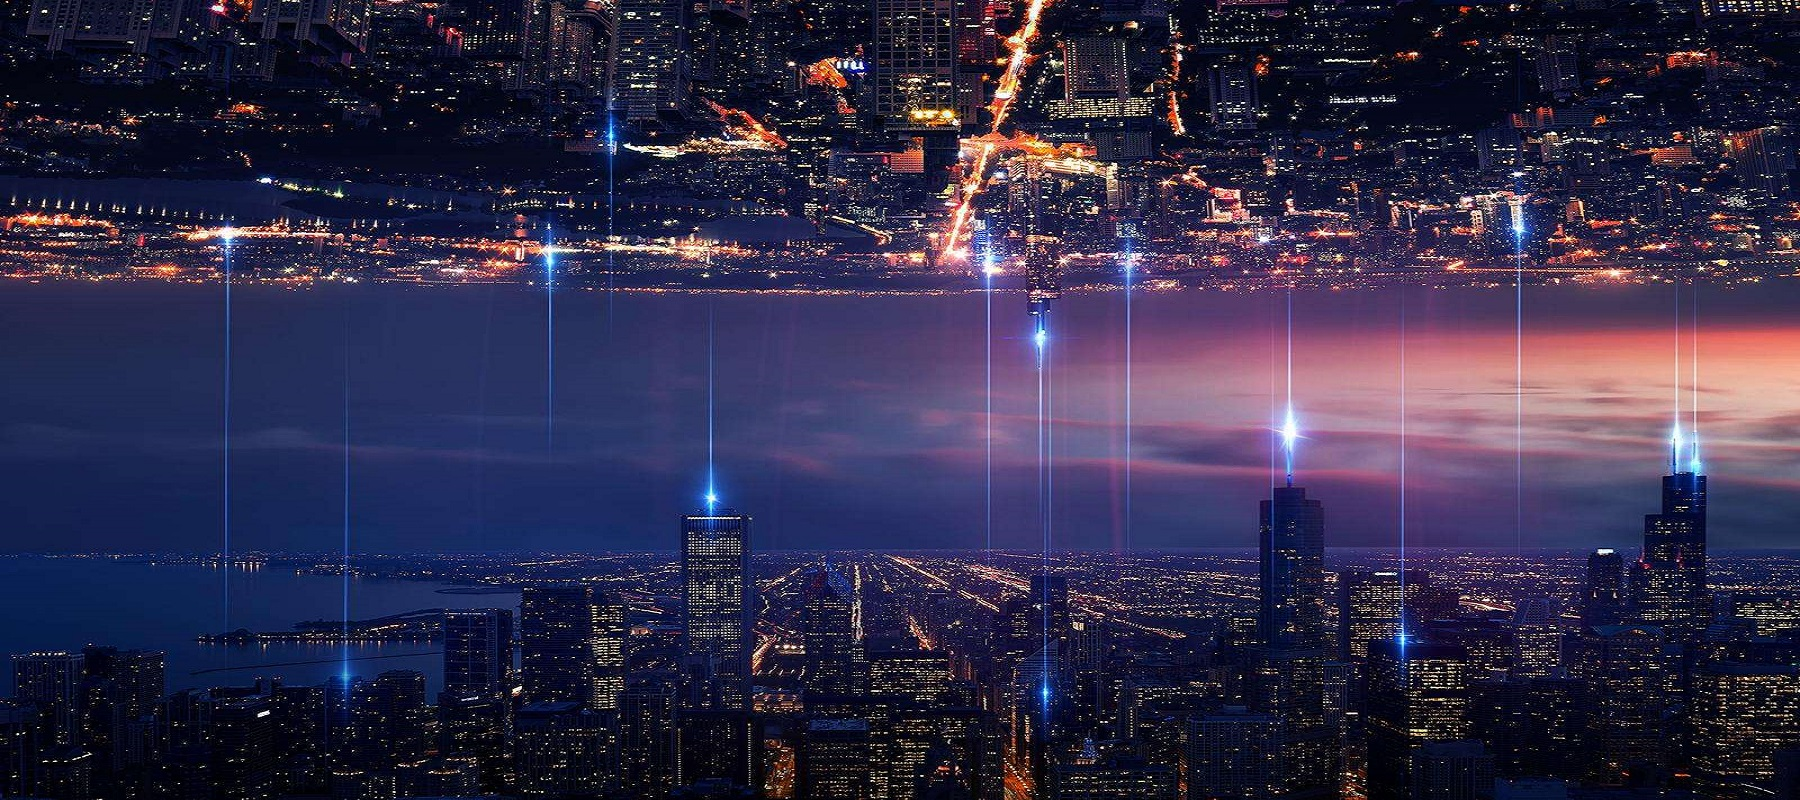
# Introduction：
### In this notebook, we will forecast future sales from the perspective of time series
* **The historical sales volume of each commodity is used as a separate data set to predict the future sales volume**
* We build an Encoder-Decoder LSTM.
* The input has 9 features,and only use 56 days for trainning. 
* I use the first 28days(of the last 56days) for trainning and the last 28days(of the last 56days) as labels

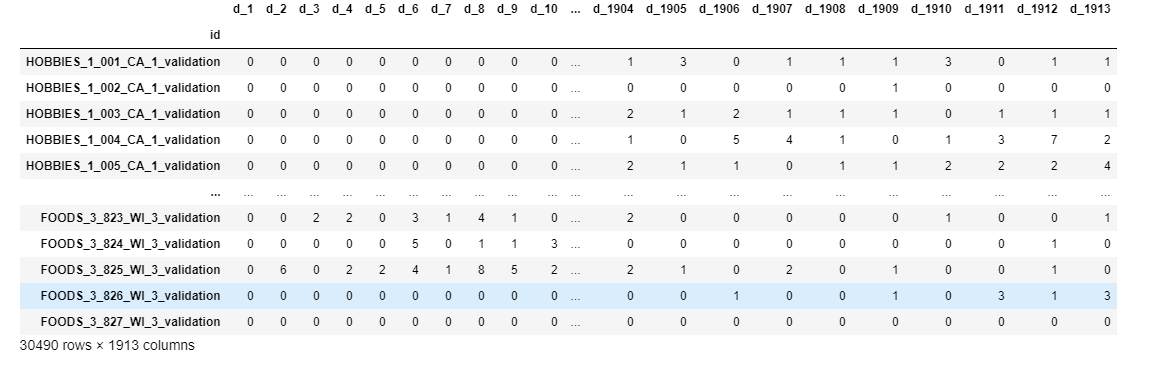

# **Contents**

* [<font size=4>Import libraries and load dataset</font>](#1)


* [<font size=4>Visualizing the Time Series(EDA)</font>](#2)
    * [Preparing the time series](#2.1)
    * [Visualizing the relationship between prices and sales](#2.2)
    * [Visualizing the relationship between event and sales](#2.3)
    * [Comparing the values under each category label](#2.4)

    
* [<font size=4>Build a LSTM Model</font>](#3)
    * [Normalize](#3.1)
    * [Why Use a TimeDistributed Layer?](#3.2)
    * [Why Use a RepeatVector Layer?](#3.3)


* [<font size=4>Make prediction</font>](#4)


# **Import libraries and load dataset** <a id="1"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from sklearn import preprocessing, metrics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from keras.layers import RepeatVector,TimeDistributed
from numpy import array
from keras.models import Sequential, load_model
#import utils_paths
import re
from tqdm import tqdm
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
train_sales = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
sell_prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
submission_file = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sample_submission.csv')

In [ ]:
num = 30490 # number of traindata

In [ ]:
def transform(data):
    
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
        
    cat = ['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data


In [ ]:
days = range(1, 1970)
time_series_columns = [f'd_{i}' for i in days]
transfer_cal = pd.DataFrame(calendar[['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']].values.T, index=['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI'], columns= time_series_columns)
transfer_cal = transfer_cal.fillna(0)
event_name_1_se = transfer_cal.loc['event_name_1'].apply(lambda x: x if re.search("^\d+$", str(x)) else np.nan).fillna(10)
event_name_2_se = transfer_cal.loc['event_name_2'].apply(lambda x: x if re.search("^\d+$", str(x)) else np.nan).fillna(10)


In [ ]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar = calendar[calendar['date']>= '2016-1-27']  #reduce memory
calendar= transform(calendar)
# Attempts to convert events into time series data.
transfer_cal = pd.DataFrame(calendar[['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']].values.T,
                            index=['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI'])
transfer_cal

In [ ]:
price_fea = calendar[['wm_yr_wk','date']].merge(sell_prices, on = ['wm_yr_wk'], how = 'left')
price_fea['id'] = price_fea['item_id']+'_'+price_fea['store_id']+'_validation'
df = price_fea.pivot('id','date','sell_price')

In [ ]:
price_df = train_sales.merge(df,on=['id'],how= 'left').iloc[:,-145:]
price_df.index = train_sales.id
price_df.head()

**So far, we have eight features from calendar and sell_prices: **
> 1. event_name_1
> 2. event_type_1
> 3. event_name_2
> 4. event_type_2
> 5. snap_CA
> 6. snap_TX
> 7. snap_WI
> 8. sell_price

# Visualizing the Time Series <a id="2"></a>

Below I make a simple plot of the first time series in the data.

##  **Preparing the time series** <a id="2.1"></a>

In [ ]:
days = range(1, 1913 + 1)
time_series_columns = [f'd_{i}' for i in days]
time_series_data = train_sales[time_series_columns]  #Get time series data

In [ ]:
#show last 28days
figsize = (25, 5)
time_series_data.iloc[15, -28:].plot(figsize=figsize)

plt.grid()
#The last 28 days
print(time_series_data.iloc[0, 1885:].shape)

##  **Try to visualize the relationship between prices and sales ** <a id="2.2"></a>

In [ ]:
def min_max(df):
    return (df-df.mean())/df.std()  #scale

In [ ]:
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')

In [ ]:
for i in range(2,6):
    price_sell = calendar.merge(sell_prices[sell_prices.item_id=='HOBBIES_1_00'+str(i)][sell_prices.store_id=='CA_1'], on = ['wm_yr_wk'], how = 'left')
    fig =plt.figure(figsize= (20, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(min_max(time_series_data.iloc[i].values))
    ax.plot(min_max(price_sell.sell_price),'-o')
    plt.legend(['sale','price'])
    ax.set_title(str(i))
    ax.set_xlabel('Time')
    ax.set_ylabel('Sales')

#### It seems that there is no obvious relationship between price and sales volume, and adding price is not easy to deal with, we temporarily give up the price feature.

## **Try to visualize the relationship between event and sales ** <a id="2.3"></a>

In [ ]:
for i in range(5,10):
    fig =plt.figure(figsize= (20, 5))
    ax = fig.add_subplot(1, 1, 1)
    #ax.bar(x = range(len(transfer_cal.loc['snap_WI'][1500:1800].values)),height = transfer_cal.loc['snap_TX'][1500:1800].values,label='snap_TX',facecolor='red')
    ax.plot(time_series_data.iloc[i, 500:800].values,label='sales')
    ax.bar(x = range(300),height = event_name_1_se[500:800].values*0.05*time_series_data.iloc[i, 500:800].values.max(),label='type_1',facecolor='black',width=1.2)
    ax.bar(x = range(300),height = event_name_2_se[500:800].values*0.05*time_series_data.iloc[i, 500:800].values.max(),label='type_2',facecolor='orange',width=1.2)
    plt.legend(['sale','event_1','event_2'])
    ax.set_title(str(i))

    ax.set_xlabel('Time')
    ax.set_ylabel('Sales')

##  Comparing the values under each category label <a id="2.4"></a>
* We need to find the groups that have the larger variance.

In [ ]:
for i in train_sales.cat_id.unique():
    fig =plt.figure(figsize= (20, 5))
    for j in range(10):
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(train_sales[train_sales.cat_id==i].iloc[j, :][time_series_columns].values)
        ax.set_title(str(i))
        ax.set_xlabel('Time')
        ax.set_ylabel('Sales')

In [ ]:
for i in train_sales.dept_id.unique():
    fig =plt.figure(figsize= (20, 5))
    for j in range(10):
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(train_sales[train_sales.dept_id==i].iloc[j, :][time_series_columns].values)
        ax.set_title(str(i))
        ax.set_xlabel('Time')
        ax.set_ylabel('Sales')

In [ ]:
for i in train_sales.store_id.unique():
    fig =plt.figure(figsize= (20, 5))
    for j in range(10):
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(train_sales[train_sales.store_id==i].iloc[j, :][time_series_columns].values)
        ax.set_title(str(i))
        ax.set_xlabel('Time')
        ax.set_ylabel('Sales')

* ### It looks like The values under category Dept_id  vary greatly.

# Build a LSTM Model <a id="3"></a>

* We build a network with a lstm layer and a dense layer.
* Input with 2 features,and only use the last 56days as train data.

In [ ]:

X = []   #build a data with two features(salse and event1)
for i in tqdm(range(time_series_data.shape[0])):
    X.append([list(t) for t in zip(transfer_cal.loc['event_name_1'][-(100+28):-(28)],
                                   transfer_cal.loc['event_type_1'][-(100+28):-(28)],
                                   transfer_cal.loc['event_name_2'][-(100+28):-(28)],     #emmmm.....Those features didn't work for me...
                                   transfer_cal.loc['event_type_2'][-(100+28):-(28)],
                                   transfer_cal.loc['snap_CA'][-(100+28):-(28)],
                                   transfer_cal.loc['snap_TX'][-(100+28):-(28)],
                                   transfer_cal.loc['snap_WI'][-(100+28):-(28)],
                                   price_df.iloc[i][-(100+28):-(28)],
                                   time_series_data.iloc[i][-100:])]) 

X = np.asarray(X, dtype=np.float32)

** Notice ** : I made a 28 days delay for event features.

Beacause I think if I want to predict the sales of 28days late, I need to give the model features from the 28days later.

*  Due to the large difference of input data, we need to use normalization.

The low and high is use to remember the lowest and highest values of train date to translate the prediction to normal size.

##  Normalize <a id="3.1"></a>

In [ ]:

def Normalize(list):
    list = np.array(list)
    low, high = np.percentile(list, [0, 100])
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = (list[i]-low)/delta
    return  list,low,high

def FNoramlize(list,low,high):
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = list[i]*delta + low
    return list

def Normalize2(list,low,high):
    list = np.array(list)
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = (list[i]-low)/delta
    return  list


## Why Use a TimeDistributed Layer? <a id="3.2"></a>
![](https://ae01.alicdn.com/kf/H0d1d47c633fb4964804a53d6ad248967T.jpg)
* In fact, the TimeDistributed layer gives the model a one-to-many, many-to-many capability and also adds dimension to the model.

## Why Use a RepeatVector Layer? <a id="3.3"></a>

*    That is, one output for each LSTM at each input sequence time step rather than one output for each LSTM for the whole input sequence.

*    An output for each step of the input sequence gives the decoder access to the intermediate representation of the input sequence each step. This may or may not be useful. Providing the final LSTM output at the end of the input sequence may be more logical as it captures information about the entire input sequence, ready to map to or calculate an output.


In [ ]:
np.random.seed(7)

 ## I only use the last 56 days for train_data.
if __name__ == '__main__':
    n_steps = 28
    train_n,train_low,train_high = Normalize(X[:,-(n_steps*2):,:])
    X_train = train_n[:,-28*2:-28,:]
    y = train_n[:,-28:,8]  #     
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 9
    n_out_seq_length =28
    num_y = 1
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    y = y.reshape((y.shape[0], y.shape[1], 1))
    print(X_train.shape)
    # define model

    model = Sequential()

    
    model.add(LSTM(128, activation='relu', input_shape=(28, n_features),return_sequences=False))
    model.add(RepeatVector(n_out_seq_length))
    model.add(LSTM(32, activation='relu',return_sequences=True))
   #model.add(Dropout(0.1))  
    model.add(TimeDistributed(Dense(num_y)))   # num_y means the shape of y,in some problem(like translate), it can be many.
                                                #In that case, you should set the  activation= 'softmax'
    model.compile(optimizer='adam', loss='mse')
    # demonstrate prediction
    model.fit(X_train, y, epochs=10, batch_size=1000)

# Make prediction <a id="4"></a>
* We are using the last 28days to predict the future.

In [ ]:
x_input = array(X_train[:,-n_steps*1:])
x_input = x_input.reshape((num, n_steps*1, n_features))
print(x_input.shape)
#x_input = Normalize2(x_input,train_low,train_high)
yhat = model.predict(x_input[:,-n_steps:], verbose=0)
x_input=np.concatenate((x_input[:,:,8].reshape(x_input.shape[0],x_input.shape[1]),yhat.astype(np.float32).reshape(x_input.shape[0],x_input.shape[1])),axis=1).reshape((x_input.shape[0],x_input.shape[1]+28,1))
#print(yhat)
print(x_input.shape)

In [ ]:
x_input = FNoramlize(x_input,train_low,train_high)
x_input = np.rint(x_input)

In [ ]:
forecast = pd.DataFrame(x_input.reshape(x_input.shape[0],x_input.shape[1])).iloc[:,-28:]
forecast.columns = [f'F{i}' for i in range(1, forecast.shape[1] + 1)]
forecast[forecast < 0] =0
forecast.head()

In [ ]:
validation_ids = train_sales['id'].values
evaluation_ids = [i.replace('validation', 'evaluation') for i in validation_ids]

In [ ]:
ids = np.concatenate([validation_ids, evaluation_ids])

In [ ]:
predictions = pd.DataFrame(ids, columns=['id'])
forecast = pd.concat([forecast]*2).reset_index(drop=True)
predictions = pd.concat([predictions, forecast], axis=1)

In [ ]:
predictions.to_csv('submission.csv', index=False)  #Generate the csv file.

# Conclusion:
* The encode-decode model and more features didn's improve score a lot. 
* But it is also an attempt,maybe this architecture can help you guys in other problems.

This notebook is based on the notebook by RDizzl3 : https://www.kaggle.com/rdizzl3/eda-and-baseline-model

Content structure from https://www.kaggle.com/tarunpaparaju/m5-competition-eda-models  by @tarunpaparaju

Encoder-Decoder LSTM:https://machinelearningmastery.com/learn-add-numbers-seq2seq-recurrent-neural-networks/
--Jason Brownlee

TimeDistributed:https://keras.io/zh/layers/wrappers/

Because I wanted to make a simple version first, So I only used the last 56 days for training.

<font size=3 color="red">This is my first public notebook,Welcome to upvote,Thanks! I will keep improve the model.</font>
